In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN
from qiskit.utils import QuantumInstance, algorithm_globals

from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

seed = 71
np.random.seed = seed

In [2]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [3]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [4]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

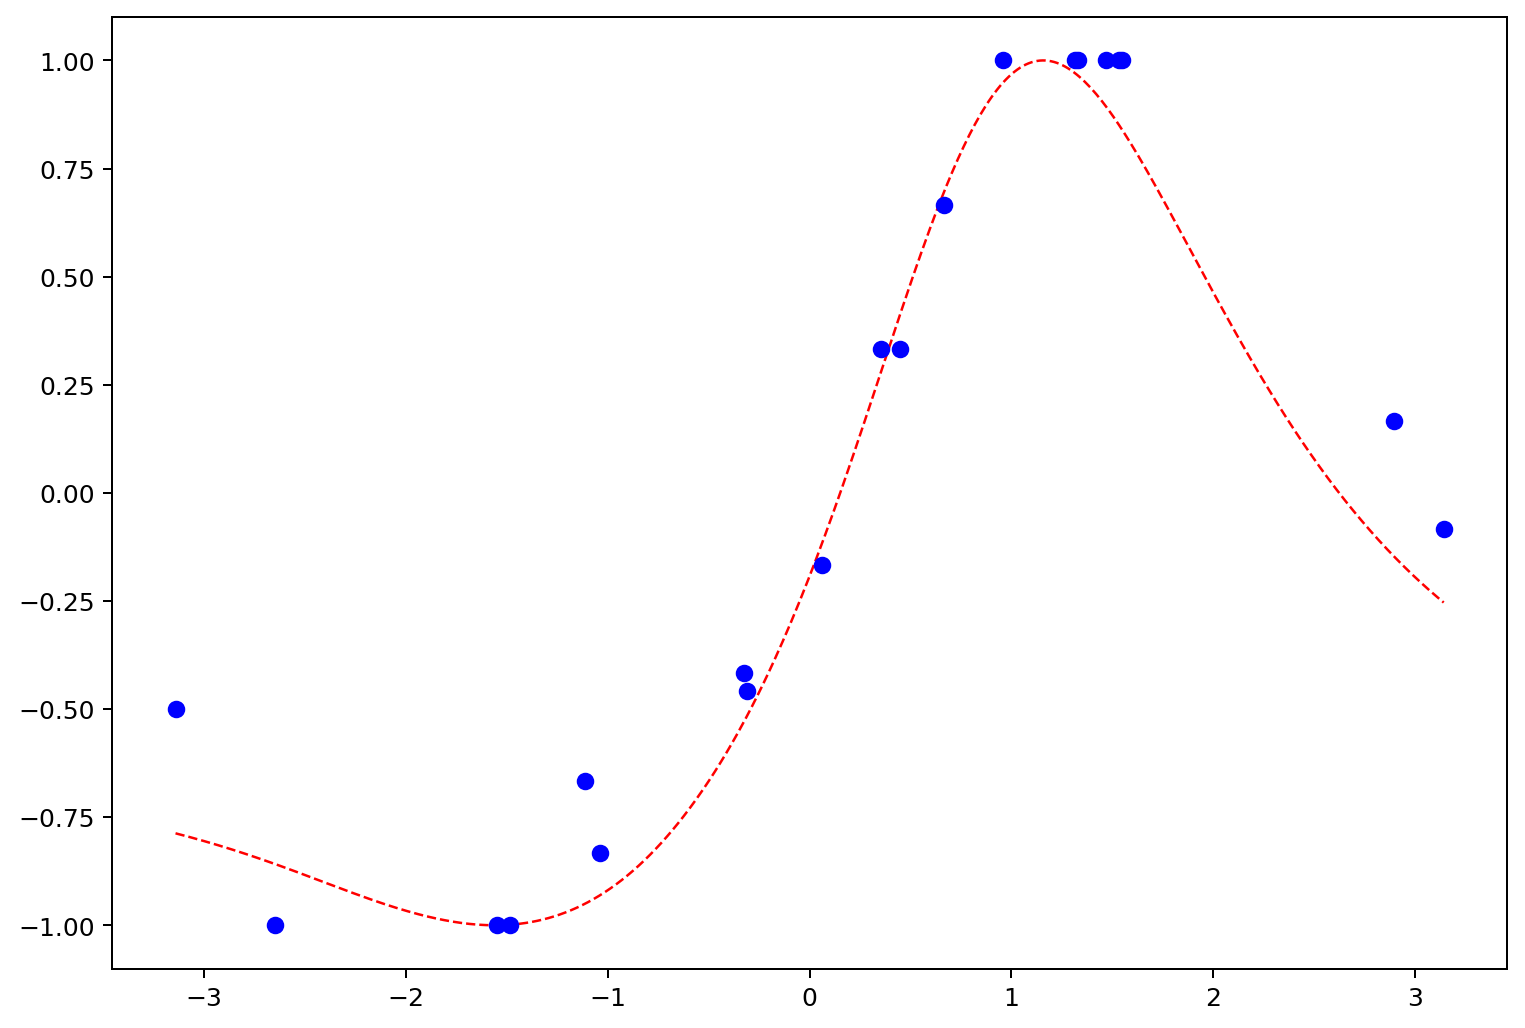

In [5]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [16]:
real_data = y_.reshape(y_.shape[0],)

In [17]:
real_data.shape

(450,)

In [18]:
bounds = np.array([-1.0, 1.0])

num_qubits = [2]

# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 2

# Batch size
batch_size = 1

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1

# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed
)

# Set entangler map
entangler_map = [[0, 1]]


# Set an initial state for the generator circuit as a uniform distribution
# This corresponds to applying Hadamard gates on all qubits
init_dist = QuantumCircuit(sum(num_qubits))
init_dist.h(init_dist.qubits)

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement=entangler_map, reps=1)

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
init_params = yy.flatten().tolist()

# You can increase the number of training epochs and use random initial parameters.
# init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)

# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)

# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

In [19]:
# Run qGAN
result = qgan.run(quantum_instance)

In [20]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [ 0.23048762  0.70658007 -0.56003671 ...  0.03612209 -0.21207703
 -0.0085962 ]
  params_g : [-0.93991401 -1.38978007 -1.4378567  -1.08615047 -0.66666667 -0.83333333
 -0.41666667 -0.45833333 -0.16666667  0.33333333  0.33333333  0.66666667
  1.          1.          1.          1.          1.          1.
  0.16666667 -0.08333333]
  loss_d : 0.6498
  loss_g : [0.8455]
  rel_entr : 0.1812


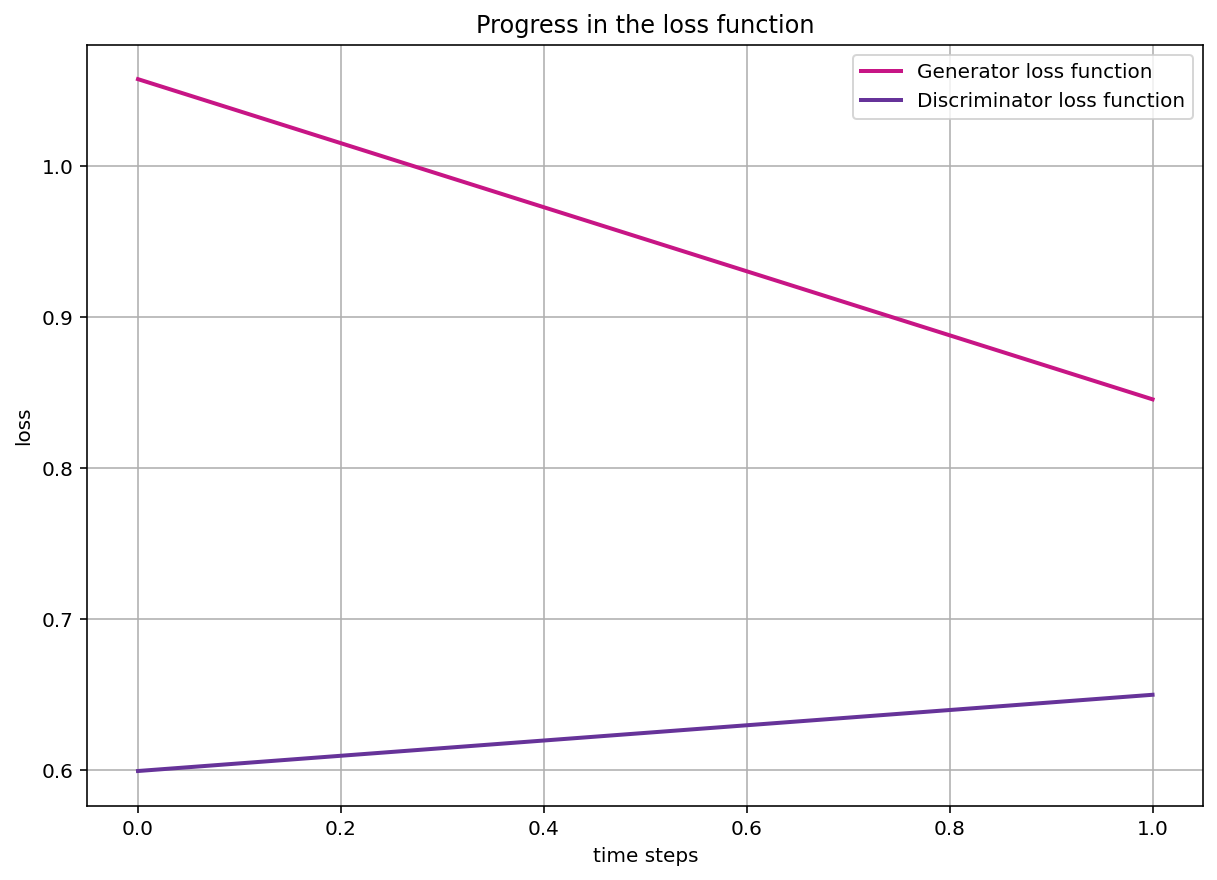

In [21]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)

plt.title("Progress in the loss function")

plt.plot(
    t_steps, qgan.g_loss, label="Generator loss function", color="mediumvioletred", linewidth=2
)

plt.plot(
    t_steps, qgan.d_loss, label="Discriminator loss function", color="rebeccapurple", linewidth=2
)

plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

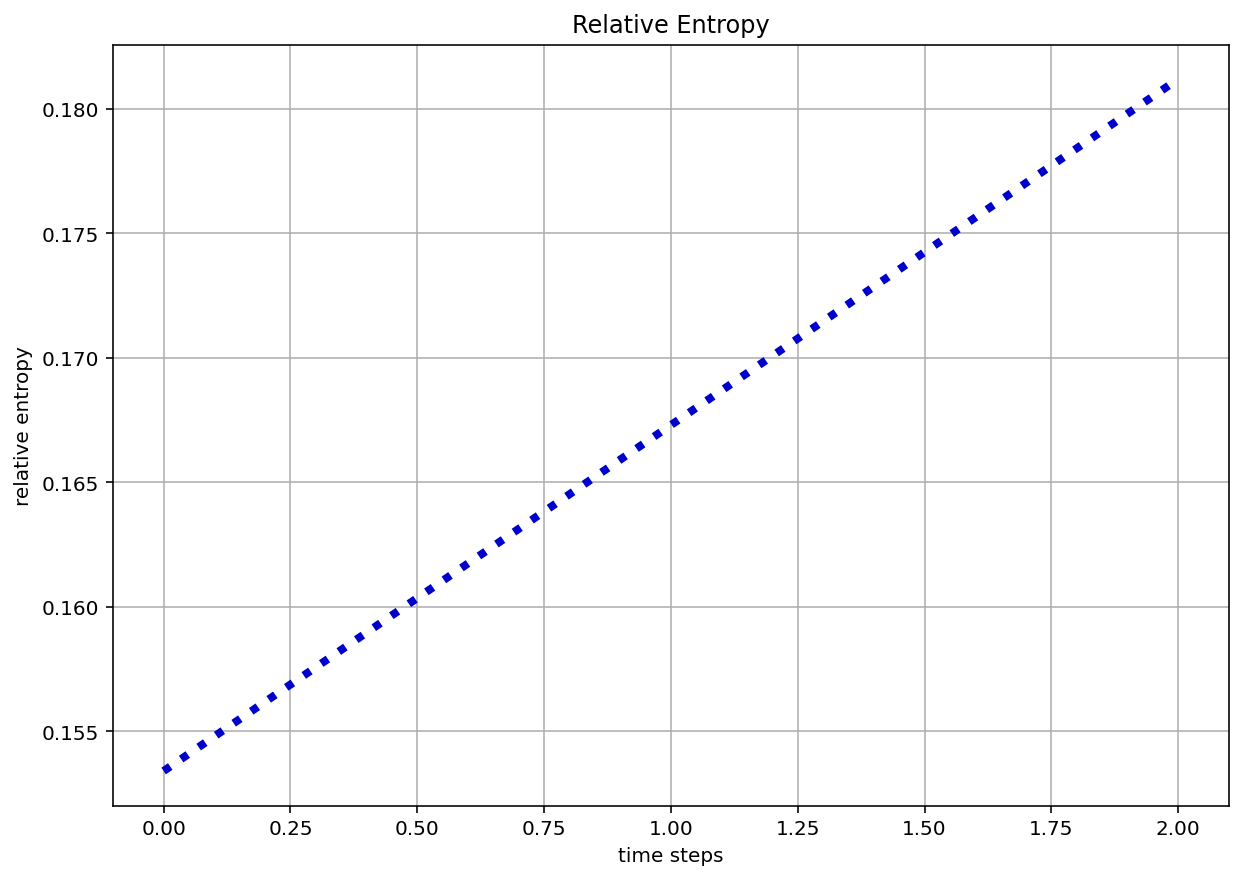

In [22]:
# Plot progress w.r.t relative entropy

plt.title("Relative Entropy")
plt.plot(
    np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color="mediumblue", lw=4, ls=":"
)
plt.grid()
plt.xlabel("time steps")
plt.ylabel("relative entropy")
plt.show()

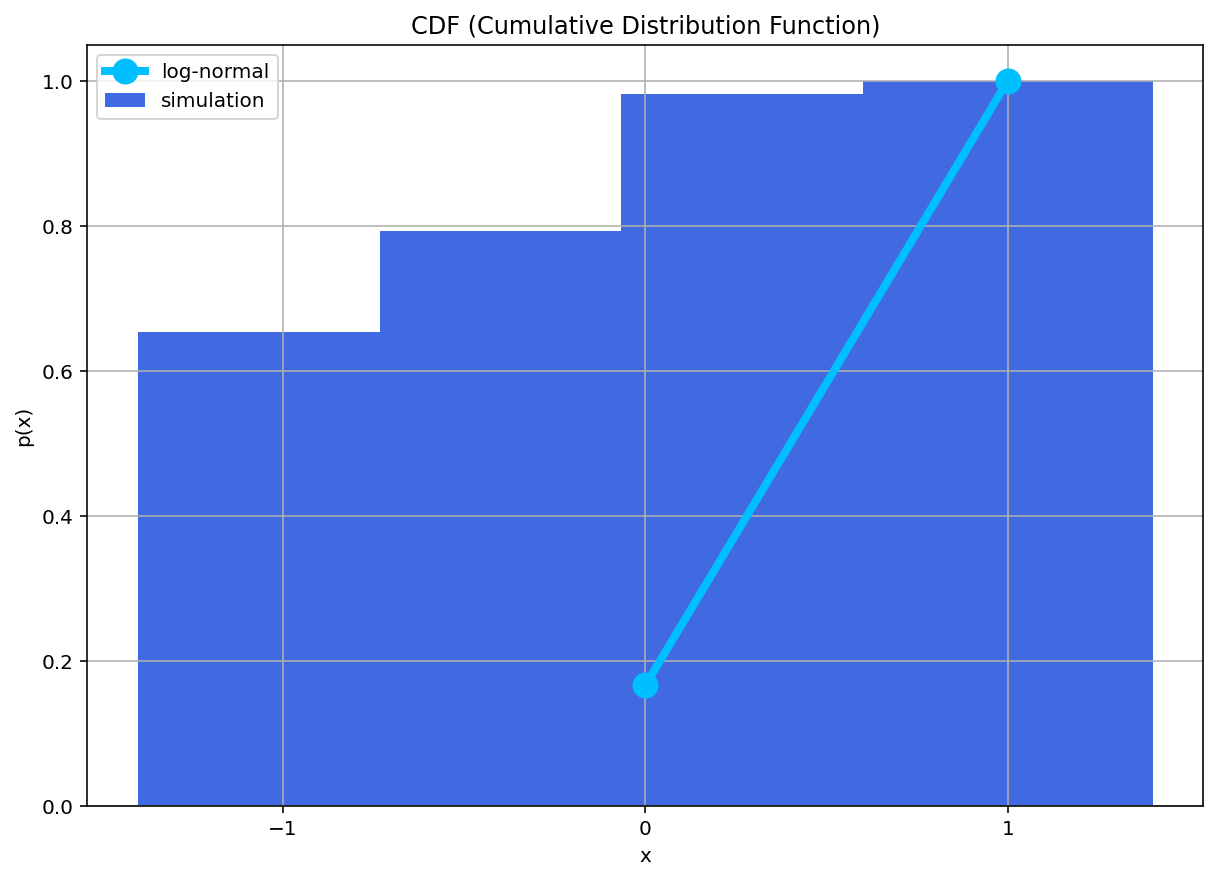

In [23]:
# Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal == i)]
log_normal = np.array(temp / sum(temp))


plt.title("CDF (Cumulative Distribution Function)")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()

num_bins = len(prob_g)

plt.bar(samples_g, np.cumsum(prob_g), color="royalblue", width=0.8, label="simulation")

plt.plot(
    np.cumsum(log_normal), "-o", label="log-normal", color="deepskyblue", linewidth=4, markersize=12
)

plt.xticks(np.arange(min(samples_g), max(samples_g) + 1, 1.0))
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")
plt.show()

In [24]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright